# UDAP Final Project Report: Evaluating Companies’ Information Privacy Policy
**Group Member: Tingting Gu, Yuwei Zhu**
<br>
<br>
[<img src="https://www.cyberark.com/wp-content/uploads/2020/01/Data-Privacy.jpg" width="600"/>](https://www.cyberark.com/wp-content/uploads/2020/01/Data-Privacy.jpg)

## Table of Content
1. [Overview](#Overview)
2. [Anlysis Pipeline](#Analysis-Pipeline)
3. [Data preprocessing](#Data-preprocessing)
4. [Basic Text Analysis](#Basic-Text-Analysis)
5. [Clustering](#Clustering)
6. [Topic Modeling](#Topic-Modeling)
7. [Sentiment Analysis](#Sentiment-Analysis)
8. [Summary](#Summary)
9. [Appendix](#Appendix)

## Overview

Over the years, technology has revolutionized our world and daily lives. While technology presents us with abundance of tools and resources, it threatens our information privacy through constant information/data collection. 

To address people's concern, government and enterprises have increased their efforts to protect users' data privacy. In May 2018, the European Union implemented the GDPR (General Data Protection Regulation), which incorporates consideration on legitimate interest, data portability, right to erasure, breach notification, and protection. The U.S., on the contrary, only has several state-level regulations such as California Consumer Privacy Act (CCPA), urging organizations operating in California to implement and maintain security procedures and practices to protect user data. 

Although companies has been updating thier information privacy terms with public, the transparency in the type of data companies collect and how they keep our data remains in the black box as most common customers never spend their time on reading the privacy policies.

In this project, we would like to decompose companies' data privacy policy and understand them through the lens of specific categories. We would connect the dots between what people are concerned about and what companies collect, hoping to create more transparency in company privacy policies. We are interested in the following questions: 

1. Do people express special concerns towards certain data privacy practices on social media? 
2. How do companies' privacy policies vary from each other? Can we spot any clusters of companies? 
3. Can we identify any categories/topics in the privacy policies? 


## Analysis Pipeline

In this project, we mainly employed three machine learning models: KMeans Clustering, LDA Topic Modeling, Sentiment Analysis. 

First, we use the clustering methods at company level to identify similar companies. Then, we applied LDA topic modeling on corpus at paragraph level to get meaning topics. We combined results from these two methods to answer the question of privacy policy composition and variances among companies. Next, we used the topics identified as keyword to extract relevant post from Twitter API. In the end, we analyzed people's response under each topic.

<div>
<img src="pipeline.png" width="500"/>
</div>
<br>
<center>Picture 1: Analysis Pipeline</center>

In [0]:
# import library
import pandas as pd
import numpy as np
import lxml.html as lh
import glob
import os
import re
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import preprocessor as p
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import LatentDirichletAllocation

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Data Preprocessing

To analyze companies’ data privacy terms/documents and customers' focus on data privacy issues, we first utilize the data provided by the [Usable Privacy Policy Project](#https://usableprivacy.org/data). The final dataset we picked is the ACL/COLING 2014 Dataset, a corpus of 1,010 privacy policies from the top websites ranked on Alexa.com. The privacy policies in the dataset were retrieved in December 2013 and January 2014. The format of each privacy policy is `XML`.

In [0]:
# load privacy policy data
# data source: https://usableprivacy.org/data
corpus = []
company_names = []
# loop through all files in the dataset
for filename in glob.glob('./corpus/*.xml'):
    company_name = os.path.basename(filename).split('.')[0]
    path = os.path.abspath(filename)
    with open(path) as f:
        page = f.read()
        tree = lh.fromstring(page)
        corpus.append(str(tree.text_content()))
    company_names.append(company_name)

In [0]:
df = pd.DataFrame(columns = ['company'], data = company_names)
df['corpus'] = corpus

In [0]:
df.head()

,company,corpus
0,www_google_co_nz,\n \n \n Privacy Policy\n\nLa...
1,ibnlive_in,\n \n \n Privacy Policy\nIBN7...
2,www_gocomics,\n \n \n Privacy Policy\n\nAt...
3,www_petsmart,\n \n \n This document provid...
4,www_duolingo,\n \n \n Privacy Policy\n ...


In [0]:
# data preprocessing
nlp = spacy.load('en', disable=['ner'], max_length = 1000000000)

In [0]:
# split corpus into paragraph level for topic modeling
para_corpus = [para for i in corpus for para in i.split('\n    \n    \n        ') ]
# create index to keep company information
para_corpus_index = [idx for idx, i in enumerate(corpus) for para in i.split('\n    \n    \n        ')]

nlp_text_para = [nlp(text) for text in para_corpus]

In [0]:
# create tokenized text
nlp_text_para_token = []
for doc in nlp_text_para:
    para_token = []
    for token in doc:
        lemma = token.lemma_.lower()
        if not (nlp.vocab[lemma].is_stop or token.pos_ == 'PUNCT' or token.pos_ == 'SPACE'):
            para_token.append(lemma)
    nlp_text_para_token.append(para_token)

In [0]:
# combine words from list to paragraphs (string)
nlp_text_para_token_combined = [' '.join(i) for i in nlp_text_para_token]

## Basic Text Analysis
### Overview

In [0]:
# average number of words per paragraph
avg_words = np.array([len(i) for i in nlp_text_para_token]).mean()
# total number paragraphs
num_paras = len(nlp_text_para_token)

print('The dataset has total number of {0:5d} paragraphs.'.format(num_paras))
print('On average, there are {0:.2f} paragraphs for each privacy polity.'.format(num_paras/1100))
print('On average, there are {0:.2f} words for each paragraph.'.format(avg_words))

The dataset has total number of 10538 paragraphs.
On average, there are 9.58 paragraphs for each privacy polity.
On average, there are 137.16 words for each paragraph.


In [0]:
# helper function: create word cloud
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
spacy_stopwords.add('pron') # elimilate -pron-
def wordcloud(text, max_words):
    wordcloud = WordCloud(width = 600,
                          height = 400, 
                          background_color="white",
                          stopwords = spacy_stopwords,
                          max_words = max_words).generate(text)
    plt.figure(figsize=(8,6))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    return

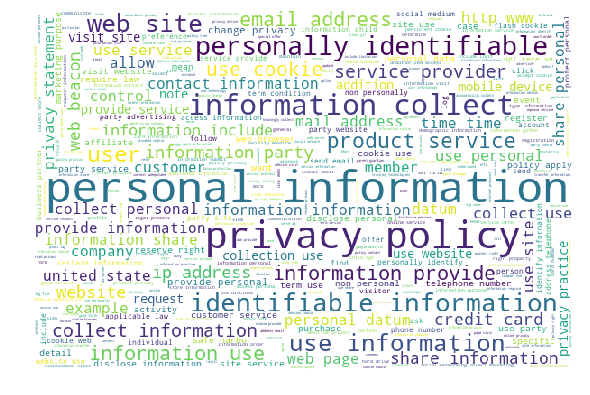

In [0]:
wordcloud(' '.join(nlp_text_para_token_combined), 400)

### Top words

In [0]:
# count word frequency
word_count = Counter()
for para in nlp_text_para_token:
    for word in para:
        word_count[word] += 1

In [0]:
 word_count_sorted = sorted(word_count.items(), reverse=True, key=lambda x:x[1])

# print top 10 words
print('{0:5s}{1:15s}{2:10s}'.format('Rank', 'Lemma', 'Raw Count'))
for idx,pair in enumerate(word_count_sorted[:10]):
    word, count = pair
    print('{0:<5d}{1:15s}{2:^5d}'.format(idx+1, word, count))

Rank Lemma          Raw Count 
1    -pron-         215747
2    information    62759
3    use            31127
4    service        18374
5    site           17617
6    privacy        17538
7    personal       17072
8    provide        13918
9    policy         13604
10   party          13515


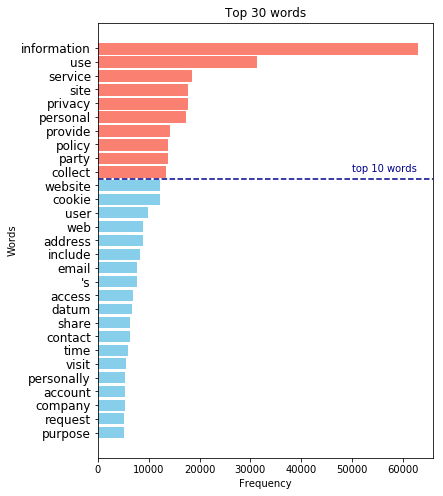

In [0]:
# create two list storing top 30 words and corresponding raw count
# drop -pron-
ents = [pair[0] for pair in word_count_sorted[1:30]]
counts = [pair[1] for pair in word_count_sorted[1:30]]

# plot histogram
plt.figure(figsize = (6,8))
barlist = plt.barh(range(len(counts)), counts, color = 'skyblue')
plt.gca().invert_yaxis() # reverse bar plot
# top 10 words with different color
for i in range(10):
    barlist[i].set_color('salmon')
# annotate top 10 words    
plt.axhline(y = 9.5, color = 'darkblue', linestyle = '--')
plt.annotate(s = 'top 10 words', xy = (50000,9), color = 'darkblue')

plt.yticks(range(len(counts)), ents, fontsize = 'large')
plt.ylabel('Words')
plt.xlabel('Frequency')
plt.title('Top 30 words')
plt.show()

# Clustering
To begin with, we applied Kmeans clustering methods on the data to idenfity companies sharing similar privacy poliy.

In [0]:
# initiate the vectorizer
vectorizer = TfidfVectorizer(min_df = 50, max_df = 0.8, stop_words = 'english')
X = vectorizer.fit_transform(corpus).toarray() # used on docs

print('Number of unique words: ' + str(len(vectorizer.vocabulary_)))

Number of unique words: 1740


In [0]:
best_k = None
best_labels = None
best_score = -1
best_model = None

scores_kmeans = {}

for k in range(2, 20):
    
    kmeans = KMeans(n_clusters = k, random_state = 999)
    kmeans.fit(X)
    
    labels = kmeans.labels_
    score = silhouette_score(X, labels)
    scores_kmeans[k] = score
    #print('k =', k, 'has silhouette score', score)
    
    if score > best_score:
        best_score = score
        best_k = k
        best_model = kmeans
        best_labels = labels

print()
print("Best k = " + str(best_k), 'according to silhouette score')
print()



Best k = 15 according to silhouette score



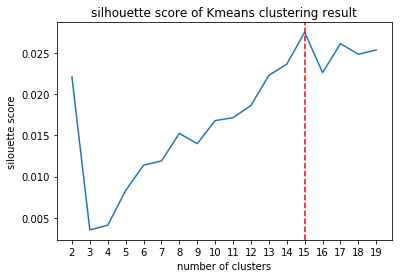

In [0]:
plt.plot(list(scores_kmeans.keys()), list(scores_kmeans.values()))
plt.axvline(x = best_k, color = 'r', linestyle = '--')
plt.xticks(list(scores_kmeans.keys()))
plt.ylabel('silouette score')
plt.xlabel('number of clusters')
plt.title('silhouette score of Kmeans clustering result')
plt.show()

In [0]:
n_clusters = best_k
kmeans = KMeans(n_clusters = n_clusters, random_state = 999)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=15, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=999, tol=0.0001, verbose=0)

In [0]:
df['kmeans_cluster_assignments'] = kmeans.labels_

In [0]:
cluster_group = df.groupby('kmeans_cluster_assignments')

In [0]:
for cluster in range(15):
    company = list(cluster_group.get_group(cluster)['company'])
    print(cluster)
    print(company)

0
['www_opentable', 'www_drugstore', 'www_saksfifthavenue', 'www_oracle', 'www_staples', 'bitpay', 'www_gm', 'www_jcpenney', 'www_officedepot', 'www_verizon', 'www_forever21', 'www_nhl', 'www_amazon_co_jp', 'www_bedbathandbeyond', 'www_target', 'www_anthropologie', 'www_gamestop', 'www_bestbuy', 'help_overstock', 'www_nextag', 'shop_nordstrom', 'www_dell', 'www_potterybarn', 'www_zappos', 'www_amazon_ca', 'www_6pm', 'www_nvidia', 'www_frys', 'www_americanexpress', 'www_usbank', 'www_honda', 'cms_paypal', 'www_shopathome', 'www_modcloth', 'www_homedepot', 'online_citibank', 'www_ikea', 'www_jcrew', 'info_yahoo', 'www_imdb', 'www_victoriassecret', 'www_zendesk', 'www_hostgator', 'www_ae', 'www_landsend', 'www_christianbook', 'customerservice_macys', 'www_amazon_co_uk', 'www_urbanoutfitters', 'www_williams-sonoma', 'www_paypal', 'help_play', 'www_amazon', 'customerservice_bloomingdales', 'www_llbean', 'www_qvc', 'www_shopbop', 'www_capitalone', 'www_neimanmarcus', 'www_bhphotovideo', 'www

In [0]:
cluster_names = ['Shopping + Bank', 'Travel', 'Lifestyle', 'Social media + News', 
                 'Online Education', "Can't identify", 
                 'Education', 'News', 'Entertainment', "Can't identify", 'Government', 'Google', 'Life',
                'Complex', 'University']

Based on analysis, we identifed each company cluster:

|Cluster|Company Type|Examples|# Companies|
|---|---|---|---|
|1|Shopping + Bank|Amazon, costco, gap, Capital One|78|
|2|Travle|aircanada, expedia, hyatt|121|
|3|Lifestyle|The Knot(Wedding service), Booking, NBA|73|
|4|Social Media + News|Facebook, Linkedin, Bloomberg|130
|5|Online Education|Udacity, Coursera, Duolingo|68|
|6|Can't identify|Speed test, style forum |10|
|7|Education|Cambridge, UCSD, Codecademy|17|
|8|News|NYTimes, Washington Times, Guardian|153|
|9|Entertainment|Gamepress, UFC |42|
|10|Can't identify|UN, Codecademy|67|
|11|Government|Whitehouse, Census, FDA|32|
|12|Google|google_ca, google_jp|38|
|13|Life|Weather, Weekly standard|22|
|14|Complex|FIFA, BitCoin, Lifehack|141|
|15|University|UCLA, Berkeley, Upenn|18|

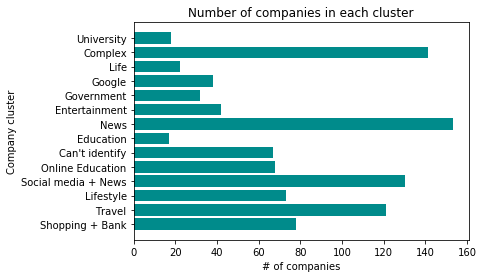

In [0]:
plt.barh(cluster_names, cluster_group.size(), color = 'darkcyan')

plt.ylabel('Company cluster')
plt.xlabel('# of companies')
plt.title('Number of companies in each cluster')
plt.show()

# Topic Modeling

Next, we employed LDA topic modeling model on the dataset at paragraph level.

Topic modeling requires the pre-processed policy to be divided into segments, each potentially dealing with a single topic. A common practice in topic modeling, which is particularly applicable for structured legal texts such as privacy policies, is to rely on the document’s division into paragraphs as a means for segmentation[1]. The idea is to get to the smallest segments possible while keeping the essence of the text, bearing in mind that even if a topic is extracted based on paragraphs that are only part of a larger topic then later on it can be joined with topics representing other parts of the larger topic. Furthermore, paragraphs can be easily identified and are
generally seen as a self-contained unit of a discourse. Therefore, we preferred the division to paragraphs due to the above-mentioned advantages. 

The data preprocessing resulted in `10538 paragraphs`. The average paragraph size was found to be `137 words`.

*1.Lu, Y., & Zhai, C. (2008). Opinion integration through semi-supervised topic modeling. In Proceeding of the 17th International Conference on World Wide Web 2008, WWW'08 (pp. 121-130). (Proceeding of the 17th International Conference on World Wide Web 2008, WWW'08). https://doi.org/10.1145/1367497.1367514*

In [0]:
vocab_size = 1740

# CountVectorizer does tokenization and can remove terms that occur too frequently, not frequently enough, or that are stop words

# document frequency (df) means number of documents a word appears in
tf_vectorizer = CountVectorizer(max_df=0.95,
                                min_df=2,
                                stop_words='english',
                                max_features=vocab_size)
vec_corpus = tf_vectorizer.fit_transform(nlp_text_para_token_combined)

In [0]:
n_topics =10

# apply LDA model with 10 topics
LDA = LatentDirichletAllocation(n_components = n_topics, max_iter = 10, n_jobs = -1, random_state = 1234)
LDA.fit(vec_corpus)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=-1,
                          perp_tol=0.1, random_state=1234,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [0]:
topic_word_distributions = np.array([row / row.sum() for row in LDA.components_])

In [0]:
top_words_number = 20

for topic_idx in range(n_topics):
    print('[Topic ', topic_idx, ']', sep='')
    sort_indices = np.argsort(-topic_word_distributions[topic_idx])
    for rank in range(top_words_number):
        word_idx = sort_indices[rank]
        print(tf_vectorizer.get_feature_names()[word_idx], ':', topic_word_distributions[topic_idx, word_idx])
    print()

[Topic 0]
information : 0.0985003888802235
use : 0.033832048355656064
collect : 0.03372265450108539
service : 0.02265998190616343
address : 0.02097776184439887
provide : 0.01811076233145754
site : 0.01728929539128226
personal : 0.015910479790198388
website : 0.013788870379000564
include : 0.013785837879824158
number : 0.0114830192358916
device : 0.011158839926674649
mobile : 0.010672397402423145
services : 0.009657927326876922
application : 0.009221924288049315
social : 0.009173015770771049
personally : 0.009005001360826161
datum : 0.008168949988182166
user : 0.007747083207592519
access : 0.0077199875323793465

[Topic 1]
information : 0.04068549107512104
user : 0.03356188350943397
use : 0.030918512871793598
email : 0.025771727097419338
service : 0.023367700186827406
address : 0.018957388531066804
send : 0.016830751008375215
provide : 0.016064205957989696
message : 0.015521058464927497
site : 0.013012791615456156
member : 0.011217376334350418
post : 0.010110617394991823
public : 0.00991

We asked information security professional to help us to identify content under each topic. With her help, we successfully identify the main content of each topics:

- Topic 1: Social Media privacy
- Topic 2: Personal Identifiable Info
- Topic 3: Privacy Regulation/Law
- Topic 4: Browser Level (online surfing information)
- Topic 5: Targeted Advertising/Online Surfing
- Topic 6: Specific Mention on Safe Harbor -- indicating company doing in the EU
- Topic 7: The topic doesn't make sense
- Topic 8: Health Information Protection / Private Health Information
- Topic 9: Privacy Notice
- Topic 10: User Consent/ terms agreement

Next, we will combine the topic modeling result with clustering to check the topic distribution for each company cluster.

In [0]:
topic_names = ['Social Media privacy','Personal Identifiable Info','Privacy Regulation/Law',
              'Browser Level (online surfing information)','Targeted Advertising/Online Surfing',
              'Specific Mention on Safe Harbor -- indicating company doing in the EU',
              "The topic doesn't make sense",
              'Health Information Protection / Private Health Information',
              'Privacy Notice', 'User Consent/ terms agreement']

In [0]:
company_topics_prob = vec_corpus.dot(topic_word_distributions.T)
# normalize topics
company_topics_normal = np.divide(company_topics_prob, company_topics_prob.sum(axis = 1).reshape(10538,1))
company_topics = np.argsort(-company_topics_normal)
# get topic assignment for each paragraph
assigned_topics_para = company_topics[:,0]

/Users/zhuyuwei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
# create dataframe to store topic assignment, company information and cluster information
assigned_topics_df = pd.DataFrame(columns = ['company_index', 'topic'])
assigned_topics_df['company_index'] = para_corpus_index
assigned_topics_df['topic'] = assigned_topics_para

assigned_topics_cluster_df = pd.merge(assigned_topics_df, df.reset_index(), 
                                      how = 'left', left_on = 'company_index', right_on = 'index')

In [0]:
# count number of paragraphs of each topic for each cluster
cluster_topic_count = assigned_topics_cluster_df.groupby(['kmeans_cluster_assignments','topic'])\
                          .agg({'topic': 'count'})\
                          .rename(columns = {'topic': 'count'}).reset_index()

In [0]:
# add rows count = 0 to df
for topic in range(n_topics):
    for cluster in range(n_clusters):
        if cluster_topic_count.loc[(cluster_topic_count['kmeans_cluster_assignments'] == cluster) & 
                                    (cluster_topic_count['topic'] == topic)].empty:
            cluster_topic_count = cluster_topic_count.append({'kmeans_cluster_assignments':cluster,
                                                             'topic': topic, 'count': 0},ignore_index=True)                                

In [0]:
# sort dataframe by cluster assignment and topic
cluster_topic_count = cluster_topic_count.sort_values(by = ['kmeans_cluster_assignments', 'topic'],ascending=True)

In [0]:
# get total number of paragraphs in each cluster
cluster_topic_sum = cluster_topic_count.groupby('kmeans_cluster_assignments')\
                        .agg({'count':'sum'}).reset_index().rename(columns = {'count':'sum'})

# combine two datafram and calculate topic percentage
cluster_topic_count = pd.merge(cluster_topic_count, cluster_topic_sum, 
                               how = 'left', left_on = 'kmeans_cluster_assignments',
                            right_on = 'kmeans_cluster_assignments')

cluster_topic_count['percent'] = cluster_topic_count['count']/cluster_topic_count['sum']

In [0]:
cluster_topic_count.head()

,kmeans_cluster_assignments,topic,count,sum,percent
0,0,0,298,873,0.341352
1,0,1,3,873,0.003436
2,0,2,72,873,0.082474
3,0,3,67,873,0.076747
4,0,4,78,873,0.089347


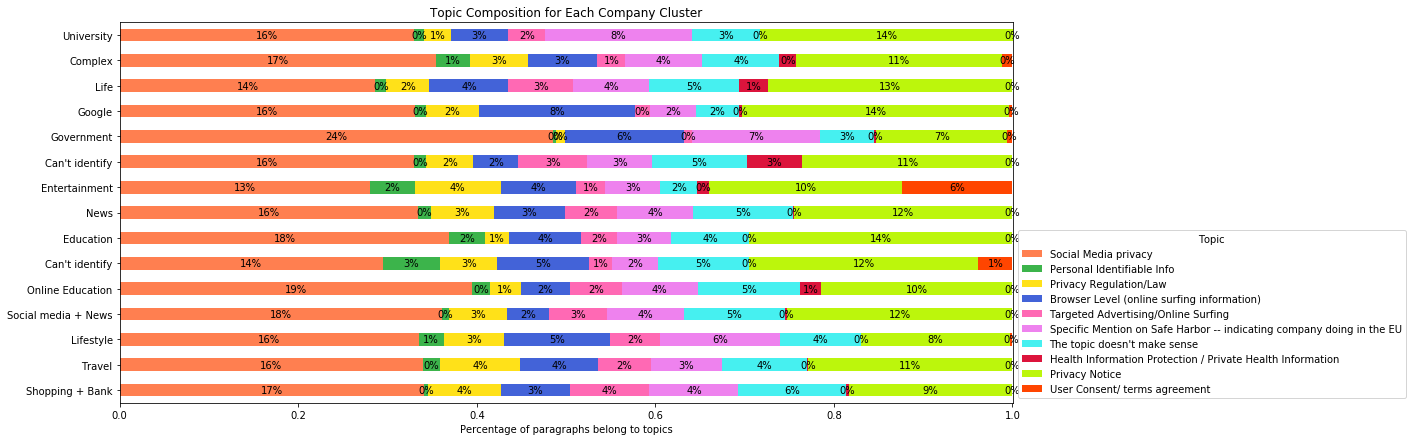

In [0]:
# create graph
fig, ax = plt.subplots(figsize=(16,7))  

topics = cluster_topic_count['topic'].drop_duplicates()
margin_bottom = np.zeros(len(cluster_topic_count['kmeans_cluster_assignments'].drop_duplicates()))
colors = ['coral', '#3cb44b', '#ffe119', '#4363d8', 'hotpink', 
          'violet', '#46f0f0', 'crimson', '#bcf60c', 'orangered', 'greenyellow',
         'goldenrod', 'cornflowerblue', 'lightcoral', 'cadetblue', 'thistle']

for num, topic in enumerate(topics):
    values = list(cluster_topic_count[cluster_topic_count['topic'] == topic].loc[:, 'percent'])
    cluster_topic_count[cluster_topic_count['topic'] == topic].plot.barh(x='kmeans_cluster_assignments',
                                                                        y='percent', ax=ax, stacked=True, 
                                    left = margin_bottom, color = colors[num], label=topic_names[num])
    
    widths = np.array(values)/2
    xcenters = margin_bottom + widths

    for y, (x, c) in enumerate(zip(xcenters, widths)):
        ax.text(x, y, '{0:.2}%'.format(str(int(c*100))), ha='center', va='center', color='black')
    
    margin_bottom += values

plt.legend(title = 'Topic', bbox_to_anchor=(1, 0), loc='lower left')
plt.yticks(range(n_clusters), cluster_names)
plt.xlabel('Percentage of paragraphs belong to topics')
plt.ylabel('')
plt.title('Topic Composition for Each Company Cluster')
plt.show()


From the plot above, we noticed that:
- Social media privacy, privacy notice, browser level information, safe harbor are the most popular topics for all company clusters.
- Although all companies privacy policy contains contents regarding personal identifiable information, it only takes a small portion of the total corpus.
- Entertainment companies pay special attention on user consent.


## Sentiment Analysis
With the extracted topics, we are now interested in knowing the general public's sentiment towards each one. We will use twitter data as the basis for sentiment analysis. In order to obtain the information corresponding to each topic, we used the following search query for the tweet extraction:

- Social Media privacy -> Social Media Privacy 
- Personal Identifiable Info -> Personal Identifiable Information 
- Privacy Regulation -> Privacy Regulation
- Browsing Level Information -> Web Browsing Privacy 
- Targeted Advertising -> Targeted Advertising 
- Specfic Mentions on safe harbor -> GDPR (General Data Protection Regulation, comprehensive document on privacy protection in the EU) 
- Health Information Protection -> HIPPA (Health Information Privacy Protection Act) 
- Privacy Notice -> Privacy Notice 
- User Consent -> User data consent 

### Understanding of sentiment categorization and subjectivity

- Polarity - sentiment assignment 

tweet with polaririty score = 0, nuetral assigned 
tweet with polaririty score > 0, positive assigned 
tweet with polaririty score < 0, negative assigned 


- Subjectivity - public opinion vs factual information

subjectivity range from (0-1) with 0 being a factual information and 1 being an opinion. When we see a highly subjective positive/negative sentiment, we can deduce the emotional scale of that sentiment. If a tweet is highly subjectively negative, then it amplifies the sentiment. 

We use subjectivity as another layer to understand the scale of sentiment regarding different information privacy type

In [0]:
# data load from extracting twitter files 
df_ppi = pd.read_csv('Twitter_data/PPI.csv',index_col=0)
df_tta = pd.read_csv('Twitter_data/target_adv.csv', index_col=0)
df_web_brows = pd.read_csv('Twitter_data/web_brows.csv',index_col=0)
df_health = pd.read_csv('Twitter_data/health_inf.csv',index_col=0)
df_EU = pd.read_csv('Twitter_data/gdpr.csv',index_col=0)
df_priv_notice = pd.read_csv('Twitter_data/priva_notice.csv',index_col=0)
df_user_consent = pd.read_csv('Twitter_data/user_consent.csv',index_col=0)
df_regulation = pd.read_csv('Twitter_data/priv_regulation.csv',index_col=0)
df_sm = pd.read_csv('Twitter_data/social_media.csv',index_col=0)

### Data Processing Steps 
1. using external package preprocessor to clean common characters in tweet text 
2. remove punctuation 
3. drop data with missing text 
4. after initial cleaning, drop duplicates in tweets text 
5. assign sentiment score for each text

In [0]:
def sentiment_analysis (data): # helper function for sentiment score assignement 
    assign = lambda txt: 'neutral' if txt==0 else ('positive' if txt > 0 else 'negative')
    data['score'] = data['cleaned_text'].apply(lambda txt: TextBlob(txt).sentiment.polarity)
    data['compounded_score'] = data['score'].apply(lambda txt: assign(txt))
    return data

In [0]:
def preprocess_text(data): # tweet text preprocessing helper
    data = p.clean(data)
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    data = re.sub(r'http\S+', '', data)
    for char in data.lower():
        if char in punctuations: 
            data = data.replace(char,'')      
    return data

In [0]:
def dataset_processing(df): # dataset preprocessing 
    df.dropna(subset=['text'], inplace=True) # dropping tweet with na in text 
    df['cleaned_text']= df['text'].apply(lambda txt: preprocess_text(txt)) # preprocess tweet text 
    df.drop_duplicates(subset='cleaned_text', keep="first",inplace = True) # dropping duplicates 
    df.reset_index(inplace = True)
    df = sentiment_analysis (df) # assign sentiment score 
    return df

In [0]:
# data preprocessing 
df_ppi = dataset_processing(df_ppi)
df_tta = dataset_processing(df_tta)
df_web_brows = dataset_processing(df_web_brows)
df_health = dataset_processing(df_health)
df_EU = dataset_processing(df_EU)
df_priv_notice = dataset_processing(df_priv_notice)
df_user_consent = dataset_processing(df_user_consent)
df_regulation = dataset_processing(df_regulation)
df_sm = dataset_processing(df_sm)
list_df = [df_ppi,df_tta,df_web_brows,df_health,df_EU,df_priv_notice,df_user_consent,df_regulation,df_sm]

### Top Word for Tweets 
In this section, we would like to see top frequently appeared word 


In [0]:
all_df = pd.concat(list_df) 
twitter_nlp = [nlp(i) for i in all_df['cleaned_text']]
word_count = Counter()
for tweet in twitter_nlp:
    for token in tweet:
        if not (nlp.vocab[token.lemma_.lower()].is_stop or token.pos_ == 'PUNCT' or token.pos_ == 'SPACE'):
            word_count[token.lemma_.lower()] +=1 
word_count_tweet = sorted(word_count.items(), key=lambda x: -x[1])

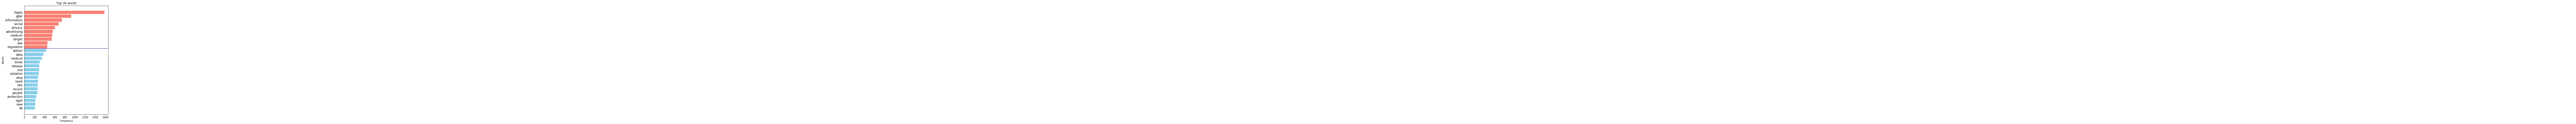

In [0]:
# manually dropping meaningless token word 
drop_word = ['-pron-','…','’s','s']
ents = [pair[0] for pair in word_count_tweet[0:30] if pair[0] not in drop_word]
counts = [pair[1] for pair in word_count_tweet[0:30] if pair[0] not in drop_word]

# plot histogram
plt.figure(figsize =(6,8))
barlist = plt.barh(range(len(counts)), counts, color = 'skyblue')
plt.gca().invert_yaxis() # reverse bar plot
# top 10 words with different color
for i in range(10):
    barlist[i].set_color('salmon')
# annotate top 10 words    
plt.axhline(y = 9.5, color = 'darkblue', linestyle = '--')
plt.annotate(s = 'top 10 words', xy = (50000,9), color = 'darkblue')
plt.yticks(range(len(counts)), ents, fontsize = 'large')
plt.ylabel('Words')
plt.xlabel('Frequency')
plt.title('Top 30 words')
plt.show()

### Sentiment Graphs
#### Graph Collection 1
 -- pair of both sentiment spread graph and subjectivity graphy 
#### Graph Collection 2 
 -- polarity score distribution from tweets across all topics 
#### Graph Collection 3 
 -- pie chart for all topic to display the composition of different sentiment and ratio 
 

In [0]:
def sentiment_analysis_graph1(df):
    analysis_spread = Counter()
    analysis_subjectivity = {'positive_subjectivity':[],'neutral_subjectivity':[],'negative_subjectivity':[]}
    
    for i in range(len(df)):

        analysis = TextBlob(df.loc[i,'cleaned_text']) 
        if analysis.sentiment.polarity > 0: 
                analysis_spread['positive'] +=1
                analysis_subjectivity['positive_subjectivity'].append(analysis.sentiment.subjectivity)
        elif analysis.sentiment.polarity == 0: 
                analysis_spread['neutral'] +=1
                analysis_subjectivity['neutral_subjectivity'].append(analysis.sentiment.subjectivity)
        else: 
                analysis_spread['negative'] +=1
                analysis_subjectivity['negative_subjectivity'].append(analysis.sentiment.subjectivity)
    for key, values in analysis_subjectivity.items():
        analysis_subjectivity[key] = sum(values)/len(values)
    
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    key = ['positve','negative','neutral']
    val = [analysis_spread['positive'],analysis_spread['negative'],analysis_spread['neutral']]
    key2 = ['positive_subjectivity','negative_subjectivity','neutral_subjectivity']
    val2 = [analysis_subjectivity['positive_subjectivity'],analysis_subjectivity['negative_subjectivity'],analysis_subjectivity['neutral_subjectivity']]
    sns.barplot(x=key, y=val,ax=axes[0],palette='RdBu',saturation=3.4)
    sns.barplot(x=key2, y=val2,ax=axes[1],palette='RdBu',saturation=3.4)
    axes[0].set_xticklabels(key, rotation=45)
    axes[1].set_xticklabels(key2,rotation=45)
    axes[0].set_title('Sentiment Spread',fontsize=10)
    axes[1].set_title('Average Subjectivity Score',fontsize=10)
    plt.show()
    

#### Graph Collection 1

Personally Identifiable Information


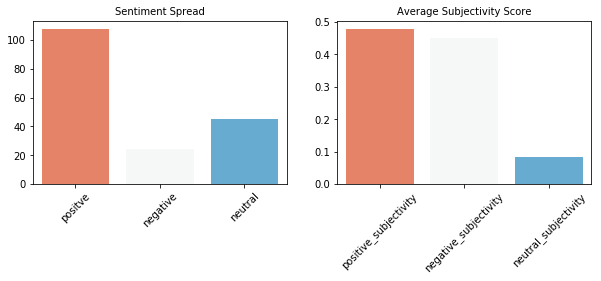

Targeted Advertising


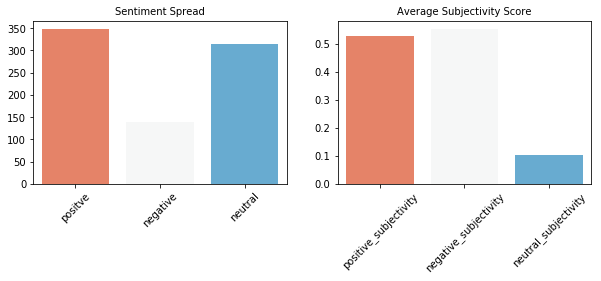

Web Browsing


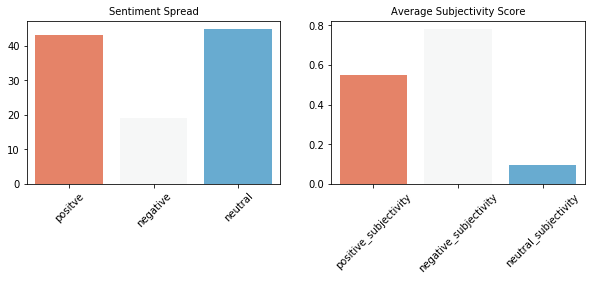

Health Info


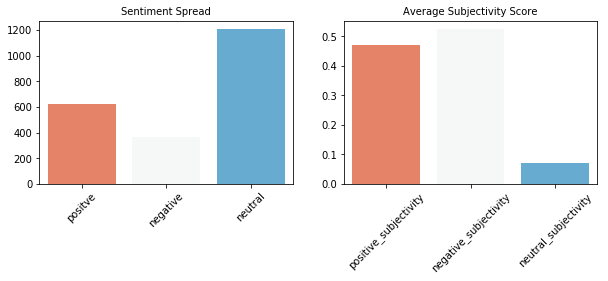

EU-based


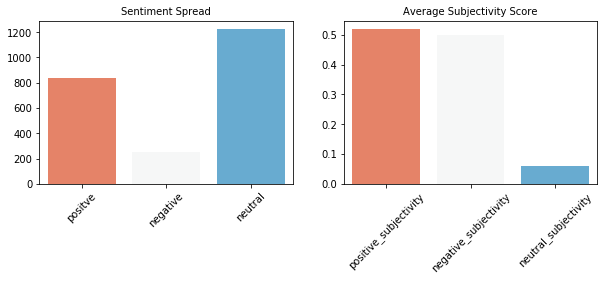

Privacy Notice


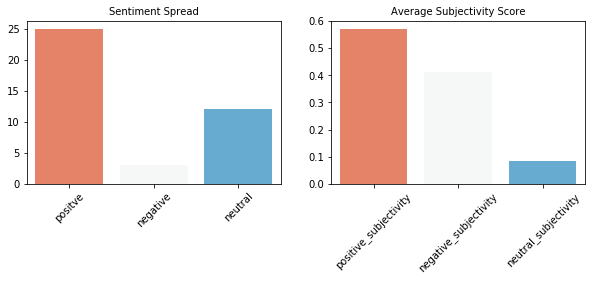

User Consent


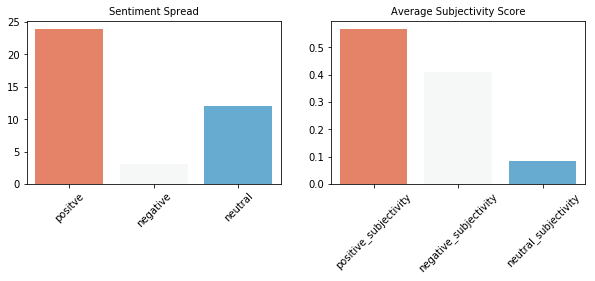

Privacy Regulation


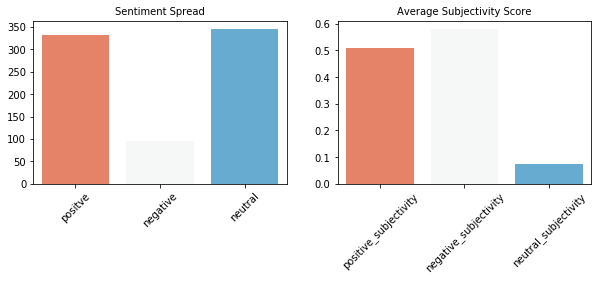

Social Media Info


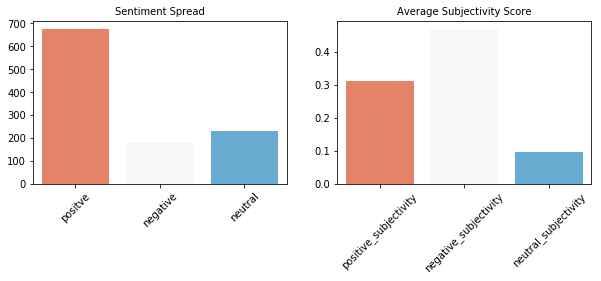

In [0]:
labels = ['Personally Identifiable Information','Targeted Advertising','Web Browsing','Health Info','EU-based',\
              'Privacy Notice','User Consent','Privacy Regulation','Social Media Info']
for index, df in enumerate(list_df):
    print(labels[index])
    sentiment_analysis_graph1(df)
    

Conclusion from subjectivity : 

- PPI: pos, neg equally subjective (strong)  
- Targeted Advertising : pos, neg equally subjective (strong)  
- Web Browsing: neg slightly more subjective/ pos,neg both strong 
- Health info: pos,neg equally subjective (strong)  
- EU-based: pos,neg equally subjective (strong)  
- Privacy Notice: pos slightly more subjective/ neg weaker  
- User consent: pos slightly more subjectively/ neg weaker
- Privacy Regulation: neg slightly more subjective 
- Social Media: neg stronger

In [0]:
def sentiment_analysis_graph2(df_list):
    # this graph will show the distribution of polarity score across all topics
    
    labels = ['Personally Identifiable Information','Targeted Advertising','Web Browsing','Health Info','EU-based',\
             'Privacy Notice','User Consent','Privacy Regulation','Social Media Info']
    num_bins = 50
    cmap = plt.get_cmap('RdBu')
    colors = [cmap(i) for i in np.linspace(0, 4, 40 )]
    
    weights1 = np.ones_like(df_list[0]['score'])/float(len(df_list[0]['score']))
    weights2 = np.ones_like(df_list[1]['score'])/float(len(df_list[1]['score']))
    weights3 = np.ones_like(df_list[2]['score'])/float(len(df_list[2]['score']))
    weights4 = np.ones_like(df_list[3]['score'])/float(len(df_list[3]['score']))
    weights5 = np.ones_like(df_list[4]['score'])/float(len(df_list[4]['score']))
    weights6 = np.ones_like(df_list[5]['score'])/float(len(df_list[5]['score']))
    weights7 = np.ones_like(df_list[6]['score'])/float(len(df_list[6]['score']))
    weights8 = np.ones_like(df_list[7]['score'])/float(len(df_list[7]['score']))
    weights9 = np.ones_like(df_list[8]['score'])/float(len(df_list[8]['score']))
   
   
    plt.figure(figsize=(10,6))
    plt.hist(df_list[0]['score'], num_bins, alpha=0.7, weights = weights1,\
                                label=labels[0],color=colors[0])
    plt.hist(df_list[1]['score'], num_bins, alpha=0.7, weights = weights2,\
                                label=labels[1],color=colors[1])
    plt.hist(df_list[2]['score'], num_bins, alpha=0.7, weights = weights3,\
                                label=labels[2],color=colors[2])
    plt.hist(df_list[3]['score'], num_bins, alpha=0.7, weights = weights4,\
                                label=labels[3],color=colors[3])
    plt.hist(df_list[4]['score'], num_bins, alpha=0.7, weights = weights5,\
                                label=labels[4],color=colors[4])
    plt.hist(df_list[5]['score'], num_bins, alpha=0.7, weights = weights6,\
                                label=labels[5],color=colors[5])
    plt.hist(df_list[6]['score'], num_bins, alpha=0.7, weights = weights7,\
                                label=labels[6],color=colors[6])
    plt.hist(df_list[7]['score'], num_bins, alpha=0.7, weights = weights8,\
                                label=labels[7],color=colors[7])
    plt.hist(df_list[8]['score'], num_bins, alpha=0.5, weights = weights9,\
                                label=labels[8],color=colors[8])
    
    
    plt.xlabel('Polarity')
    plt.ylabel('Ratio')
    plt.title('Histogram of polarity')
    plt.legend()
    plt.show()

#### Graph Collection 2

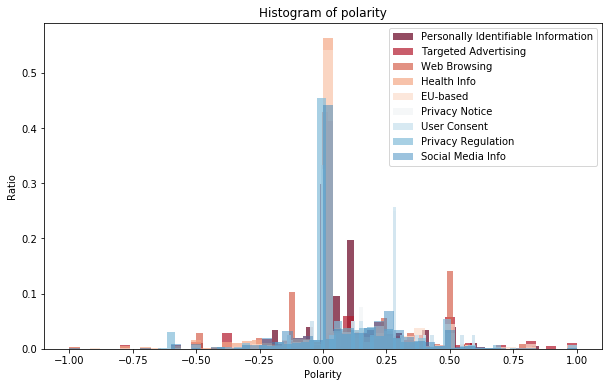

In [0]:
sentiment_analysis_graph2(list_df)  

In [0]:
def bar_char_graph (ds):
    # this graph plots ratio across sentiment 
    labels = ['positive','negative','neutral']
    sizes = [ds.compounded_score.tolist().count(i) for i in labels]
    cmap = plt.get_cmap('RdBu')
    colors = [cmap(i) for i in np.linspace(0, 20, 100 )]
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90,colors=colors)
    ax1.axis('equal')  

    plt.show()
    

#### Graph Collection 3

Personally Identifiable Information


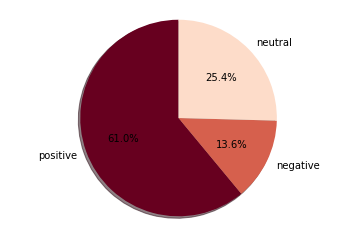


Targeted Advertising


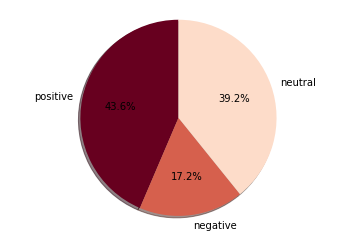


Web Browsing


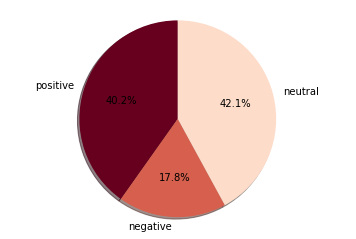


Health Info


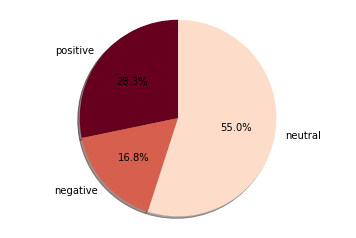


EU-based


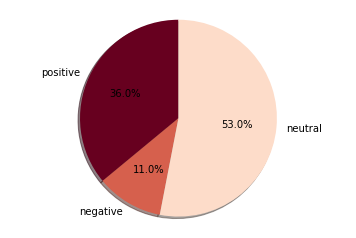


Privacy Notice


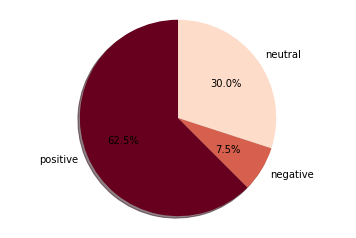


User Consent


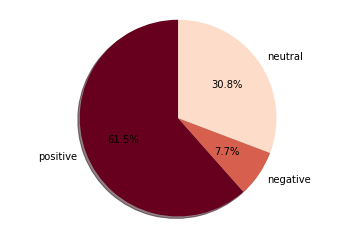


privacy regulation


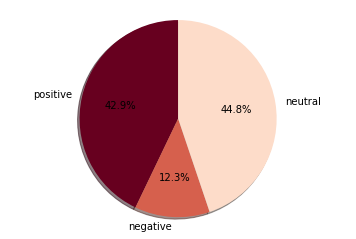


Social Media Info


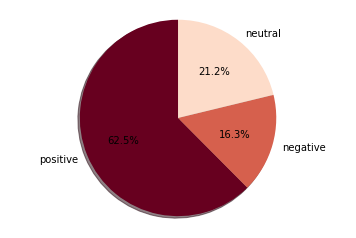

In [0]:
labels = ['Personally Identifiable Information','Targeted Advertising','Web Browsing','Health Info','EU-based',\
              'Privacy Notice','User Consent','privacy regulation','Social Media Info']
for index, df in enumerate(list_df):
    print(labels[index])
    bar_char_graph(df)
    print()

### Conclusion from sentiment distribution

Top four **negative sentiment categories** are: 

- Web browsing   17.8%
- Targed advertising  17.2%
- Health info  16.8%
- Social media info 16.3%


# Summary 

To go back to our original questions. We modified the sequence with which we answer the questions. 


1. How do companies' privacy policies vary from each other? Can we spot any clusters of companies? 
    
    **A: Companies' privacy policies can be clustered based on the business lines of the company. We identified the following categories**
       1. Shopping + Bank 
       2. Lifestyle 
       3. Online Eduation
       4. Education 
       5. News/Media 
       6. Entertainment
       7. Government/Public Sector 
       8. Life Routine 
       9. University 
       10. Others (Varieties) 
    
2. Can we identify any categories/topics in the privacy policies? 
     
     **A: Yes, there are 10 topics we identified** 
       1. Personal Identifiable Info
       2. Privacy Regulation
       3. Browsing Level Information
       4. Targeted Advertising
       5. Specfic Mentions on safe harbor
       6. Health Information Protection
       7. Privacy Notice
       8. User Consent
       9. Social Media Information
       

3. Do people express special concerns towards certain data privacy practices on social media? 
    
    **A: After obtaining a basic understanding of the topics on privacy policies, we analyzed sentiment targeted at them and found that people are particularly concerned with web browsing information, targeted advertising, health information, social media information** 
    




---
## To Put Everyting Together: 

The most concerned privacy topics comply with our intuition. The heated topic around how advertisements exploits user browsing history, social media activities and other online records to increase their liklihood of sales transactions is not foreign to us. To respond to the rising concern, governments should impose appropriate regulations on portion of company's privacy agreement document that addresses the usage of user social media, browsing data to enhance information protection. 

from looking at the distribution of topics for each company cluster, we can see that Government, Education and Lifestyle type of organizations are having high percentage of content in their privacy agreement related to the topics that the public concerns about the most. This is in fact contradictory to our initial thought on commercial use of the data. From the policy makers' perspective, it is important then to highlight these portion in their agreement to the users especially since these sectors are most likely to be overlooked by users regarding information privacy




## Appendix

### 1. Refenrece
1) [Identifying the Provision of Choices in Privacy Policy Text](https://usableprivacy.org/static/files/ksathyendra_acl_2017.pdf). Kanthashree Mysore Sathyendra, Shomir Wilson, Florian Schaub, Sebastian Zimmeck, and Norman Sadeh. Conference on Empirical Methods in Natural Language Processing (EMNLP), Copenhagen, Denmark, Sep 2017<br>
2) [Unsupervised Alignment of Privacy Policies using Hidden Markov Models](https://www.aclweb.org/anthology/P14-2099.pdf) Ramanath, Rohan, et al. "Unsupervised alignment of privacy policies using hidden markov models." Proceedings of the 52nd Annual Meeting of the Association for Computational Linguistics (Volume 2: Short Papers). 2014.

### 2. Twitter data scrapping

1.   List item
2.   List item



In [0]:
## consumer_key and consumer_secret are authorization key requested 
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)  
auth.set_access_token(access_token, access_token_secret)  
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True, compression=True)


def tweet_extraction(topic_of_concerned):
# this will take a topic and used as a query to extract twitter data and then write to a csv file 
    tweet = []
    for page in tweepy.Cursor(api.search, q=topic_of_concerned).pages(250):
        tweet.extend(page)

    tweets = [tw._json for tw in tweet]
    tweet_json = pd.DataFrame.from_records(tweets)
    tweet_json.to_csv('{}.csv'.format(topic_of_concerned))